We will use the aggregation and value counting functions developed in that notebook in order to incorporate information from the `previous_application`, `POS_CASH_balance`, `installments_payments`, and `credit_card_balance` data files.

The definitions of the four additional data files are:

* previous_application (called `previous`): previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* POS_CASH_BALANCE (called `cash`): monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance (called `credit`): monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment (called `installments`): payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

# Functions 

* `agg_numeric`: calculate aggregation statistics (`mean`, `count`, `max`, `min`) for numeric variables.
* `agg_categorical`: compute counts and normalized counts of each category in a categorical variable.

Together, these two functions can extract information about both the numeric and categorical data in a dataframe. Our general approach will be to apply both of these functions to the dataframes, grouping by the client id, `SK_ID_CURR`. For the `POS_CASH_balance`, `credit_card_balance`, and `installment_payments`, we can first group by the `SK_ID_PREV`, the unique id for the previous loan. Then we will group the resulting dataframe by the `SK_ID_CURR` to calculate the aggregation statistics for each client across all of their previous loans.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Memory management
import gc

## Function to Aggregate Numeric Data

This groups data by the `group_var` and calculates `mean`, `max`, `min`, and `sum`. It will only be applied to numeric data by default in pandas.

In [2]:
def agg_numeric(df, group_var, df_name):
    
    """
    Aggregates the numeric features in a dataframe. This can
    be used to create new features for each instance of the grouping variable.
    
    Parameters
    --------
    
    df (dataframe):
        the dataframe to calculate the statistics on
    group_var (string):
        the variable by which to group df
    df_name (string):
        the variable used to rename the columns
        
    Return
    --------
    
    agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
            
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # make a numeric dataframe and then add all the groupby features to it
    group_ids = df[group_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[group_var] = group_ids
    
    # Group by the specified variable and calculate the statistics
    numeric_agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum'])
    
    # Need to create new column names
    column_names = []
    
    # Iterate through the variables names
    for var in numeric_agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in numeric_agg.columns.levels[1]:
                 # Make a new column name for the variable and stat
                column_names.append('%s_%s_%s' % (df_name, var, stat))
                
    # rename the columns
    numeric_agg.columns = column_names
    
    # Remove the columns with all redundant values
    _, idx = np.unique(numeric_agg, axis = 1, return_index = True)
    numeric_agg = numeric_agg.iloc[:, idx]
    
    return numeric_agg

### Function to Calculate Categorical Counts

This function calculates the occurrences (counts) of each category in a categorical variable for each client. It also calculates the normed count, which is the count for a category divided by the total counts for all categories in a categorical variable. 

In [3]:
def agg_categorical(df, group_var, df_name):
    
    """
    Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))
    
    # Make sure to put the group_by var in categorical dataframe
    categorical[group_var] = df[group_var]
    
    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the variables names
    for var in categorical.columns.levels[0]:
        # Iterate through the stat names
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name for the variable and stat
            column_names.append('%s_%s_%s' % (df_name, var, stat))

    #  Rename the columns
    categorical.columns = column_names
    
    # Remove the columns with all redundant values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]

    return categorical

### Function for KDE Plots of Variable

We also made a function that plots the distribution of variable colored by the value of `TARGET` (either 1 for did not repay the loan or 0 for did repay the loan). We can use this function to visually examine any new variables we create. This also calculates the correlation cofficient of the variable with the target which can be used as an approximation of whether or not the created variable will be useful. 

In [4]:
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'target == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'target == 1')
    
    # label the plot
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('Distribution of %s by Target value' % var_name)
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' %(var_name, corr))
    
    # print out avg values
    print('Median value for loan that was repaid = %0.4f' %avg_repaid)
    print('Median value for loan that was not repaid = %0.4f' %avg_not_repaid)

# Function to Convert Data Types

This will help reduce memory usage by using more efficient types for the variables. For example `category` is often a better type than `object` (unless the number of unique categories is close to the number of rows in the dataframe).

In [1]:
import sys

def return_size(df):
    """ Return size of dataframe in gigabytes """
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for col in df:
        
        # Convert ids to integers
        if 'SK_ID' in col:
            df[col] = df[col].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[col].dtype == 'object') and (df[col].nunique() < df.shape[0]):
            df[col] = df[col].astype('category')
            
        # Booleans mapped to integers
        elif list(df[col].unique()) == [0, 1]:
            df[col] = df[col].astype(bool)
            
        # Float64 to float32
        elif df[col].dtype == float:
            df[col] = df[col].astype(np.float32)
            
        # Int64 to int32
        elif df[col].dtype == int:
            df[col] = df[col].astype(np.int32)
            
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)}gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)}gb.')
        
    return df

### previous_application

In [6]:
previous = pd.read_csv("E:/Kaggle/home-credit-default-risk/datasets/previous_application.csv")
previous = convert_types(previous, print_info = True)
previous.head()

Original Memory Usage: 0.49gb.
New Memory Usage: 0.19gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 84)


,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,...,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DRAWING_max,previous_DAYS_FIRST_DRAWING_sum,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.0,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100002,-606,-606,-606.0,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100003,-3915,-2341,-1305.0,-746,-3823.0,-2310.0,-1274.333374,-716.0,-3163.0,-1980.0,...,365243.0,365243.0,365243.0,1095729.0,NaN,NaN,NaN,NaN,NaN,NaN
100004,-815,-815,-815.0,-815,-784.0,-784.0,-784.000000,-784.0,-724.0,-724.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100005,-1072,-757,-536.0,-315,-706.0,-706.0,-706.000000,-706.0,-466.0,-466.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


We can join the calculated dataframe to the main training dataframe using a merge. Then we should delete the calculated dataframes to avoid using too much of the kernel memory.

In [9]:
train = pd.read_csv("E:/Kaggle/home-credit-default-risk/datasets/application_train.csv")
train = convert_types(train)

test = pd.read_csv("E:/Kaggle/home-credit-default-risk/datasets/application_test.csv")
test = convert_types(test)

train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

70

## Function to Calculate Missing Values

In [11]:
# Function to calculate missing values by column
def missing_values_table(df, print_info = False):
    
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = (mis_val / len(df)) * 100
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    
    # Rename the columns
    mis_val_table_rename_cols = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_rename_cols = mis_val_table_rename_cols[mis_val_table_rename_cols.iloc[:, 1] != 0] \
                                .sort_values('Missing Values', ascending = False).round(1)
        
    if print_info:
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" + 
               "There are " + str(mis_val_table_rename_cols.shape[0]) + " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_rename_cols

In [12]:
def remove_missing_columns(train, test, threshold = 90):
    
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = (train_miss[0] / len(train)) * 100
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = (test_miss[0] / len(test)) * 100
    
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [13]:
train, test = remove_missing_columns(train, test)

There are 6 columns with greater than 90% missing values.


# Applying to More Data

### Function to Aggregate Stats at the Client Level

In [14]:
def aggregate_client(df, group_vars, df_names):
    """
    Aggregate a dataframe with data at the loan level 
         at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
            
        # Count the categorical columns
        df_counts = agg_categorical(df, group_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        # Clean Memory
        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[group_vars], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
            
    # No categorical variables
    else:
            
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[group_vars], on = group_vars[0], how = 'left')

        # Clean Memory
        gc.enable()
        del df_agg
        gc.collect()

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
          
    # Clean Memory
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

## Monthly Cash Data

In [15]:
cash = pd.read_csv("E:/Kaggle/home-credit-default-risk/datasets/POS_CASH_balance.csv")
cash = convert_types(cash, print_info = True)
cash.head()

Original Memory Usage: 0.64gb.
New Memory Usage: 0.41gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [16]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
print('Cash by Client Shape: ', cash_by_client.shape)
cash_by_client.head()

Cash by Client Shape:  (337252, 165)


,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28.0,32.0,36.0,36.000000,36.0,41,41,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,456.0,361.0,456.0,456.000000,456.0,361,361,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,288.0,256.0,248.0,283.000000,288.0,272,272,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,16.0,12.0,12.0,15.000000,16.0,16,16,16,36.0,60.0
100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,132.0,99.0,99.0,128.699997,132.0,110,110,121,792.0,1287.0


In [17]:
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 650)
Testing Data Shape:  (48744, 649)


In [18]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


## Monthly Credit Data

In [19]:
credit = pd.read_csv("E:/Kaggle/home-credit-default-risk/datasets/credit_card_balance.csv")
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71gb.
New Memory Usage: 0.42gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [20]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
print('Credit by Client Shape: ', credit_by_client.shape)
credit_by_client.head()

Credit by Client Shape:  (103558, 381)


,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,2432.432373,4843.063965,4843.063965,4843.063965,55485.0,55485.0,55485.0,180000.0,180000.0,180000.0
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,6350.000000,7168.346191,7168.346191,7168.346191,153675.0,153675.0,153675.0,157500.0,157500.0,157500.0
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 1031)
Testing Data Shape:  (48744, 1030)


In [22]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


### Installment Payments

In [23]:
installments = pd.read_csv("E:/Kaggle/home-credit-default-risk/datasets/installments_payments.csv")
installments = convert_types(installments, print_info = True)
installments.head()

Original Memory Usage: 0.87gb.
New Memory Usage: 0.49gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [24]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], 
                                          df_names = ['installments', 'client'])

print('Installments by Client Shape: ', installments_by_client.shape)
installments_by_client.head()

Installments by Client Shape:  (339587, 106)


,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05


In [25]:
train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 1137)
Testing Data Shape:  (48744, 1136)


In [26]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [27]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (307511, 1137)
Final Testing Shape:  (48744, 1136)


In [28]:
print(f'Final training size: {return_size(train)} gb.')
print(f'Final testing size: {return_size(test)} gb.')

Final training size: 2.13 gb.
Final testing size: 0.34 gb.


#### Save All Newly Calculated Features

In [29]:
# train.to_csv('E:/Kaggle/home-credit-default-risk/datasets/train_previous_raw.csv', index = False, chunksize = 500)
# test.to_csv('E:/Kaggle/home-credit-default-risk/datasets/test_previous_raw.csv', index = False)

## Modeling

In [30]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [31]:

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """
    Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # extract train and test ID's
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # extract labels from train data
    labels = features['TARGET']
    
    # drop ID from train and test and also target from train
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    # in case of one-hot encoding
    if encoding == 'ohe':
        
        # make one-hot feature for each categorical feature
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        cat_indices = 'auto'
        
    # in case of label encoding    
    elif encoding == 'le':
        
        label_encoder = LabelEncoder()
        
        cat_indices = []
        
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # convert categorical features to label encoding features for both train and test set
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1, )))
                test_features[col] = label_encoder.fit_transform(np.array(test_features[col].astype(str)).reshape((-1, )))
                # keep track of categorical feature indices
                cat_indices.append(i)
                
        else:
            raise ValueError("Encoding must be either 'ohe' or 'le'")
            
    # print summary
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # extract feature names
    feature_names = list(features.columns)
    
    # convert train and test data into numpy arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # make KFold object with given no. of splits
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    feature_importance_values = np.zeros(len(feature_names))

    test_predictions = np.zeros(test_features.shape[0])
    
    out_of_fold = np.zeros(features.shape[0])
    
    # lists for tracking score of each fold (train and test dataset)
    valid_scores = []
    train_scores = []
    
    # iterate through all folds
    for train_indices, valid_indices in k_fold.split(features):
        # make train fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # make valid fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # make LightGBM object with customized parameters
        model = lgb.LGBMClassifier(n_estimators = 10000, objective = 'binary', class_weight = 'balanced',
                                   learning_rate = 0.05, reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.8,
                                   n_jobs = -1, random_state = 50)
        
        # train LightGBM on train data and evaluate on both train and valid set
        model.fit(train_features, train_labels, eval_metric = 'auc', 
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # keep track of best iteration during training
        best_iteration = model.best_iteration_
        
        # cumulative feature importances of all folds
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # cumulative test predictions of all folds
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # valid predictions of all folds
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # best accuracy score on train and valid set for each fold
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        # keep track of all train and valid best scores
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # make submission dataframe (id and predictions)
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # make feature importance dataframe (feature and importance)
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # evaluate roc_auc score on valid set predictions
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # overall train and valid score
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # list of folds
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # dataframe of metrics
    metrics = pd.DataFrame({
                'fold': fold_names,
                'train': train_scores,
                'valid': valid_scores
              })
    
    return submission, feature_importances, metrics

In [32]:
submission, feature_importances, metrics = model(train, test)

Training Data Shape:  (307511, 1256)
Testing Data Shape:  (48744, 1256)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.827022	train's binary_logloss: 0.518836	valid's auc: 0.779604	valid's binary_logloss: 0.537273
Early stopping, best iteration is:
[297]	train's auc: 0.845515	train's binary_logloss: 0.498692	valid's auc: 0.780205	valid's binary_logloss: 0.524524
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.827907	train's binary_logloss: 0.517781	valid's auc: 0.777972	valid's binary_logloss: 0.537179
Early stopping, best iteration is:
[286]	train's auc: 0.844687	train's binary_logloss: 0.499391	valid's auc: 0.778716	valid's binary_logloss: 0.525785
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.826944	train's binary_logloss: 0.519069	valid's auc: 0.781182	valid's binary_logloss: 0.538681
Early stopping, best iteration is:
[289]	train's auc: 0.844455	train's binary_logloss: 0.

In [33]:
metrics

,fold,train,valid
0,0,0.845515,0.780205
1,1,0.844687,0.778716
2,2,0.844455,0.782166
3,3,0.835495,0.780488
4,4,0.848715,0.777028
5,overall,0.843773,0.779672


In [34]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
    """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot, most important on top
    ax.barh(list(reversed(list(df.index[:15]))), df['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    
    plt.show()
    
    return df

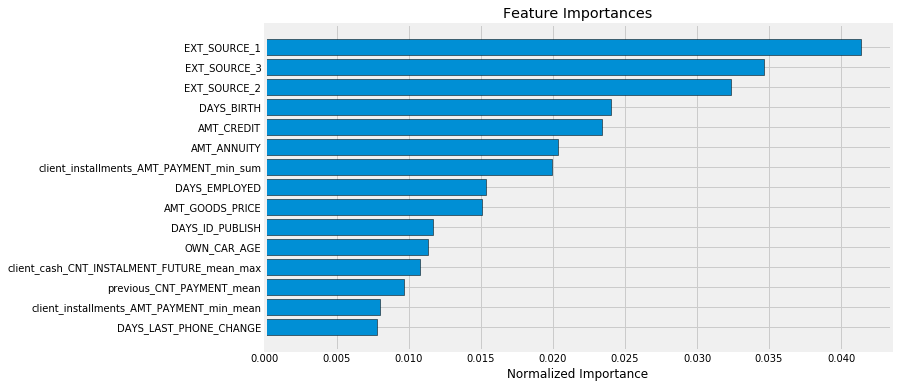

In [35]:
fi = plot_feature_importances(feature_importances)

In [36]:
submission.to_csv('E:/Kaggle/home-credit-default-risk/datasets/submissions/submission_12.csv', index = False)

In [37]:
print('Leaderboard score for submission_12.csv = 0.77229')

Leaderboard score for submission_12.csv = 0.77229
